In [ ]:

import os
import sys
sys.path.append("/home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint") # almost every `.py` need this


import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
from display_utils import display_model
import pickle
import joblib

import numpy as np
from scipy.interpolate import interp1d
from imu_base import calculate_patch_IMU_signals
import torch
from scipy.spatial.transform import Rotation as R
from imu_noise import add_imu_noise,sharpen_peaks
from inerpolate import upsample_smpl_with_jitter

/home/calatrava/anaconda3/envs/lala/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'smplpytorch'

In [ ]:
pkl_file = '/home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/example/activity22/pkl_file/wham_output.pkl'
smpl_data = joblib.load(pkl_file)
print(smpl_data[0].keys())
loaded_data = smpl_data[0]

dict_keys(['pose', 'trans', 'pose_world', 'trans_world', 'betas', 'verts', 'frame_ids'])


In [ ]:
# ----------------------------------------------------
# 1) Load original motion data
# ----------------------------------------------------
poses = loaded_data['pose']   # (N, 72)
betas = loaded_data['betas']  # (N, 10)
trans = loaded_data['trans']  # (N, 3)



In [2]:
# ----------------------------------------------------
# 2) Interpolate to high frequency
# ----------------------------------------------------
fps_original = 15
fps_high = 30
dt = 1.0 / fps_high


num_frames = poses.shape[0]
duration = num_frames / fps_original

t_original = np.linspace(0, duration, num_frames)
num_frames_high = int(duration * fps_high)
t_high = np.linspace(0, duration, num_frames_high)

# Interpolate translation
trans_high = np.zeros((num_frames_high, 3))
for d in range(3):
    f = interp1d(t_original, trans[:, d], kind='cubic')
    trans_high[:, d] = f(t_high)

# Interpolate poses (component-wise for simplicity)
poses_high = np.zeros((num_frames_high, poses.shape[1]))
for d in range(poses.shape[1]):
    f = interp1d(t_original, poses[:, d], kind='cubic')
    poses_high[:, d] = f(t_high)


NameError: name 'poses' is not defined

In [3]:
# ----------------------------------------------------
# 3) Setup SMPL layer
# ----------------------------------------------------
smpl_layer = SMPL_Layer(
    center_idx=0,
    gender='neutral',
    model_root='smplpytorch/native/models'
)

cuda = torch.cuda.is_available()
if cuda:
    smpl_layer.cuda()

NameError: name 'SMPL_Layer' is not defined

In [6]:
print(f"Generating high-freq SMPL meshes: {num_frames_high} frames at {fps_high} Hz")

all_verts = []
all_jtr = []

for i in range(num_frames_high):
    pose_params = torch.tensor(poses_high[i:i+1], dtype=torch.float32)
    shape_params = torch.tensor(betas[0:1], dtype=torch.float32)

    if cuda:
        pose_params = pose_params.cuda()
        shape_params = shape_params.cuda()

    with torch.no_grad():
        verts, Jtr = smpl_layer(pose_params, th_betas=shape_params)

    verts[:, :, 1] *= -1  # flip Y if needed
    Jtr[:, :, 1] *= -1

    # SAFE translation addition
    trans_torch = torch.tensor(trans_high[i:i+1], dtype=torch.float32)
    if cuda:
        trans_torch = trans_torch.cuda()

    verts = verts + trans_torch
    jtr = Jtr + trans_torch

    all_verts.append(verts.cpu().numpy())
    all_jtr.append(jtr.cpu().numpy())

all_verts = np.array(all_verts) 
all_jtr = np.array(all_jtr)

print(f"Verts shape: {all_verts.shape}")
print(f"Verts shape: {all_jtr.shape}")


Generating high-freq SMPL meshes: 102 frames at 30 Hz
Verts shape: (102, 1, 6890, 3)
Verts shape: (102, 1, 24, 3)


In [7]:
# ----------------------------------------------------
# 5) IMU cluster list
# ----------------------------------------------------
UTD_lists = {
    'right_wrist': {
        #'verts': [5405, 5430, 5431]
        'verts': [5669, 5705, 5430]
    },
    'right_thigh': {
        'verts': [847, 849, 957]
    }
}

In [8]:
# ----------------------------------------------------
# 6) Make height 1.75
# ----------------------------------------------------

lists = {
    'forehead': [0, 1, 5, 132, 133, 232, 234, 235, 259, 335, 336, 3512, 3513, 3514, 3515, 3517, 3644, 3645, 3646, 3676, 3744, 3745, 3746, 3771],
    'right_leg': [847, 848, 849, 850, 872, 873, 874, 875, 876, 877, 904, 905, 906, 907, 957, 1159, 1365, 1366, 1499, 1500],
    'left_leg': [4333, 4334, 4335, 4336, 4358, 4359, 4360, 4361, 4362, 4363, 4645, 4648, 4711, 4712, 4801, 4802, 4839]
}

forehead_indices = lists['forehead']
right_leg_indices = lists['right_leg']
left_leg_indices = lists['left_leg']

forehead_centroids = np.mean(all_verts[:, 0, forehead_indices], axis=1)
right_leg_centroids = np.mean(all_verts[:, 0, right_leg_indices], axis=1)
left_leg_centroids = np.mean(all_verts[:, 0, left_leg_indices], axis=1)

# Calculate centroid of legs (average of right and left)
leg_centroids = (right_leg_centroids + left_leg_centroids) / 2

# Calculate Euclidean distance between forehead and leg centroids
distances = np.linalg.norm(forehead_centroids - leg_centroids, axis=1)
average_height = np.mean(distances)
scale_factor = 1.75 / average_height

all_verts = np.array(all_verts) * scale_factor
all_jtr = np.array(all_jtr) * scale_factor

In [9]:
from imu_base import calculate_patch_IMU_signals
# ----------------------------------------------------
# 7) Compute & save for each patch IMU
# ----------------------------------------------------
save_dir = "/home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/example/activity1/pkl_file"
os.makedirs(save_dir, exist_ok=True)

for body_part, config in UTD_lists.items():
    verts = config['verts']

    print(f"Processing PATCH IMU: {body_part}")

    positions, orientations, linear_accel_loc, linear_accel_world, angular_velo = calculate_patch_IMU_signals(
        all_verts,
        verts,
        dt
    )

    file_path = os.path.join(save_dir, f'{body_part}.npz')
    np.savez(file_path,
             positions=positions,
             orientations=orientations,
             global_acceleration=linear_accel_world,
             local_accel=linear_accel_loc,
             angular_velocity=angular_velo)

    print(f"Saved PATCH IMU data: {file_path}")


Processing PATCH IMU: right_wrist
Saved PATCH IMU data: /home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/example/activity1/pkl_file/right_wrist.npz
Processing PATCH IMU: right_thigh
Saved PATCH IMU data: /home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/example/activity1/pkl_file/right_thigh.npz


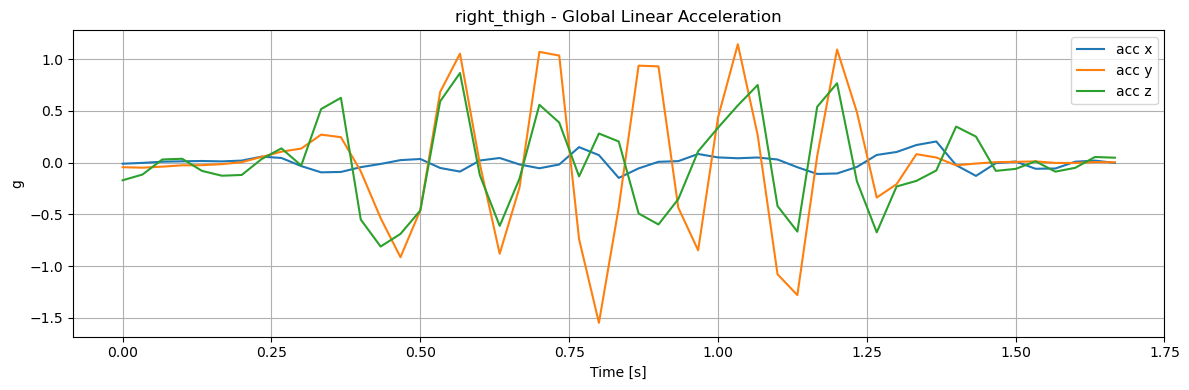

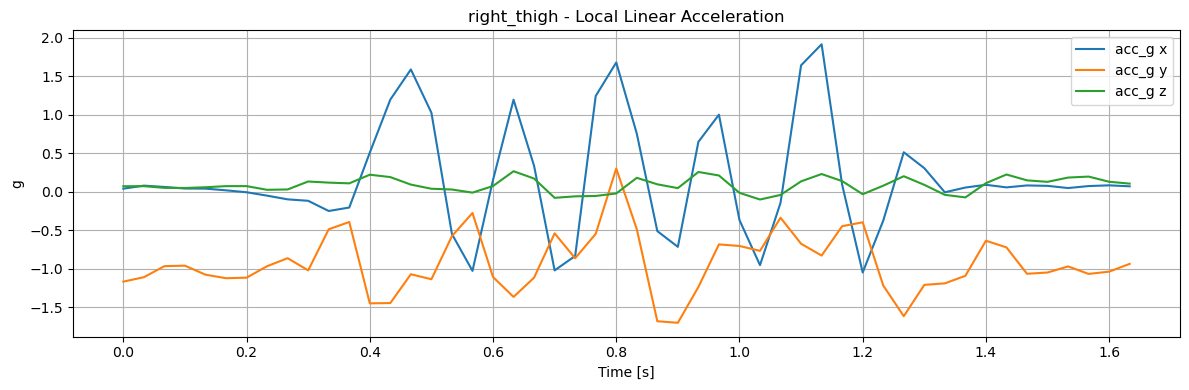

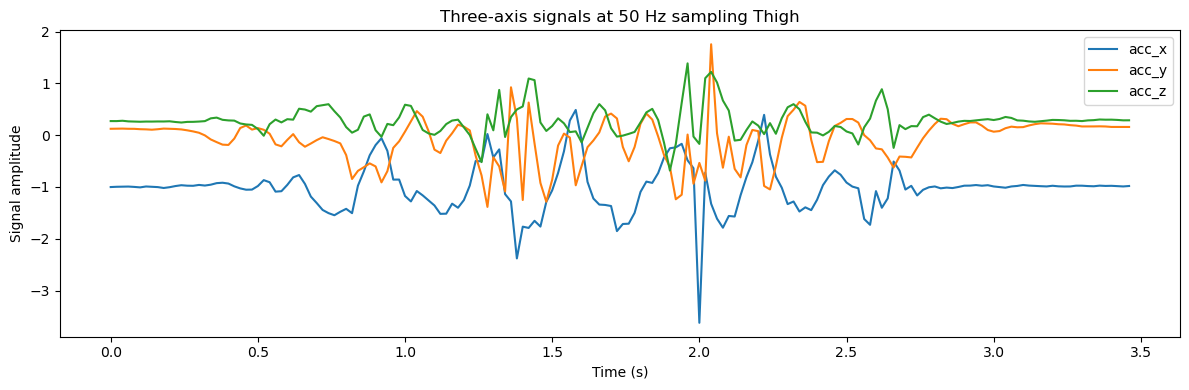

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
save_dir = r"/home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/example/activity22"
body_part = 'right_thigh'

file_path = os.path.join(save_dir, f'{body_part}.npz')
data = np.load(file_path)

acc = data['global_acceleration']
acc_g = data['local_accel']
ang_vel = data['angular_velocity']

fps = fps_high

# Time for acc
t_acc = np.arange(len(acc)) / fps

# Time for acc_g
t_acc_g = np.arange(len(acc_g)) / fps

# Time for ang_vel
t_ang = np.arange(len(ang_vel)) / fps

# --- Plot global linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Global Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc, acc[:, i]/9.81, label=f'acc {axis}')
# plt.plot(t_acc, np.linalg.norm(acc, axis=1), 'k--', label='|acc|')
plt.xlabel('Time [s]')
plt.ylabel('g')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot local linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Local Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc_g, acc_g[:, i]/9.81, label=f'acc_g {axis}')
# plt.plot(t_acc_g, np.linalg.norm(acc_g, axis=1), 'k--', label='|acc_g|')
plt.xlabel('Time [s]')
plt.ylabel('g')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


import pandas as pd
import scipy.io
 
 
real_inertial_data = scipy.io.loadmat("/home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/example/activity22/a22_s1_t1_inertial.mat")['d_iner']
 

fs = 50          # sampling frequency in Hz
dt = 1.0 / fs    # time between samples
N = real_inertial_data.shape[0]
 
# build the time vector
t = np.arange(N) * dt
 
plt.figure(figsize=(12, 4))
plt.plot(t, real_inertial_data[:, 0], label='acc_x')
plt.plot(t, real_inertial_data[:, 1], label='acc_y')
plt.plot(t, real_inertial_data[:, 2], label='acc_z')
# plt.plot(t, np.linalg.norm(real_inertial_data[:,0:3], axis=1), 'k--', label='|acc_g|')
 
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude')
plt.title('Three-axis signals at 50 Hz sampling Thigh')
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
import numpy as np, scipy.signal as sig


# 1.  Make the two alignment signals (here: magnitude)
imu_mag = np.linalg.norm(real_inertial_data[:, :3], axis=1)          # (174,)
vid_mag = np.linalg.norm(acc_g[:, :3], axis=1) / 9.81               # (50,)

vid_mag_50Hz = sig.resample(vid_mag, int(len(vid_mag) * 50 / 15))

# 2.  Cross-correlate the 1-D sequences
corr = sig.correlate(imu_mag, vid_mag_50Hz, mode='full', method='fft')
lags = sig.correlation_lags(imu_mag.size, vid_mag.size, mode='full')

# 3.  Pick the lag with the highest correlation
lag_samples = lags[np.argmax(corr)]
Δt_coarse   = lag_samples / 50.0     # seconds  (50 Hz reference)
print(f'coarse offset ≈ {Δt_coarse:.3f} s')

coarse offset ≈ 2.480 s


Estimated lag: -8 samples (-0.160 s, positive means video leads IMU)


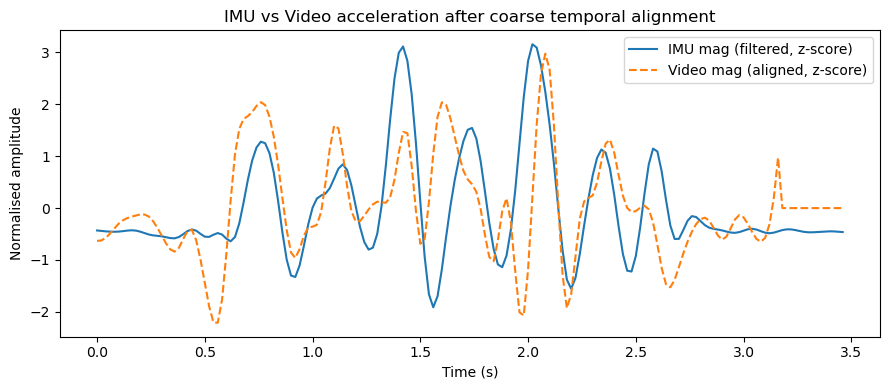

In [42]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# -----------------------------
# PARAMETERS
# -----------------------------
fs_imu   = 50.0   # Hz
fs_video = 15.0   # Hz  (nominal)

fc       = 7.0    # low-pass cutoff (Hz) ≤ video Nyquist (7.5 Hz)

# -----------------------------
# LOAD OR FAKE THE DATA
# -----------------------------
try:
    real_inertial_data   # noqa: F821
    acc_g                # noqa: F821
except NameError:
    # Fake demo data so the script runs even if the user variables
    # have not been defined in this Python kernel.
    #
    # Replace this entire block with your real arrays:
    #   real_inertial_data : (N, 3) accelerometer in m/s²
    #   acc_g             : (M, 3) simulated local-linear accel (in m/s²)
    #
    print("⚠️  Demo mode: using synthetic sine-wave data. "
          "Replace with your real 'real_inertial_data' and 'acc_g' arrays.")
    # duration_sec = 4.0
    # t_imu   = np.arange(int(duration_sec*fs_imu)) / fs_imu
    # t_video = np.arange(int(duration_sec*fs_video)) / fs_video
    # # Jogging-ish vertical accel signal
    # imu_mag   = 9.81 + 3*np.sin(2*np.pi*2*t_imu) + 0.2*np.random.randn(len(t_imu))
    # vid_mag   = 9.81 + 3*np.sin(2*np.pi*2*(t_video + 0.15))  # 150 ms offset
    # # Create 3-axis dummy arrays
    # real_inertial_data = np.column_stack([imu_mag]*3)
    # acc_g              = np.column_stack([vid_mag]*3)
else:
    # Construct magnitude signals from the provided 3-axis data
    imu_mag = np.linalg.norm(real_inertial_data[:, :3], axis=1)          # (N,)
    vid_mag = np.linalg.norm(acc_g[:, :3], axis=1) / 9.81               # (M,)
    # If acc_g is already gravity-removed, delete the “/9.81”

# -----------------------------
# LOW-PASS FILTER BOTH SIGNALS
# -----------------------------
b, a   = sig.butter(4, fc / (fs_imu/2.0), btype='low', analog=False)

imu_filt = sig.filtfilt(b, a, imu_mag)
# video sampled at 15 Hz: need filter at its own Nyquist first
b_v, a_v = sig.butter(4, fc / (fs_video/2.0), btype='low', analog=False)
vid_filt = sig.filtfilt(b_v, a_v, vid_mag)

# -----------------------------
# RESAMPLE VIDEO TO 50 Hz
# -----------------------------
len_video_resampled = int(round(len(vid_filt) * fs_imu / fs_video))
from scipy.interpolate import interp1d
t_video = np.arange(len(vid_filt)) / fs_video
t_imu   = np.arange(len_video_resampled) / fs_imu
vid_resampled = interp1d(t_video, vid_filt,
                        kind='cubic',
                        bounds_error=False,
                        fill_value="extrapolate")(t_imu)

# -----------------------------
# NORMALISE (zero-mean, unit-var)
# -----------------------------
imu_norm = (imu_filt - np.mean(imu_filt)) / np.std(imu_filt)
vid_norm = (vid_resampled - np.mean(vid_resampled)) / np.std(vid_resampled)

# -----------------------------
# CROSS-CORRELATION (1-D)
# -----------------------------
corr = sig.correlate(imu_norm, vid_norm, mode='full', method='fft')
lags = sig.correlation_lags(imu_norm.size, vid_norm.size, mode='full')
lag_samples = lags[np.argmax(corr)]
dt_coarse   = lag_samples / fs_imu  # seconds

print(f"Estimated lag: {lag_samples} samples "
      f"({dt_coarse:+.3f} s, positive means video leads IMU)")

# -----------------------------
# ALIGN THE VIDEO SIGNAL
# -----------------------------
# Shift video by padding/trimming so that both arrays have same length
if lag_samples > 0:
    vid_aligned = np.pad(vid_norm, (lag_samples, 0), 'constant')[:len(imu_norm)]
else:
    vid_aligned = vid_norm[-lag_samples:]
    if len(vid_aligned) < len(imu_norm):
        vid_aligned = np.pad(vid_aligned, (0, len(imu_norm)-len(vid_aligned)), 'constant')

t = np.arange(len(imu_norm)) / fs_imu  # common time axis

# -----------------------------
# PLOT
# -----------------------------
plt.figure(figsize=(9, 4))
plt.plot(t, imu_norm, label='IMU mag (filtered, z-score)')
plt.plot(t, vid_aligned, label='Video mag (aligned, z-score)', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Normalised amplitude')
plt.title('IMU vs Video acceleration after coarse temporal alignment')
plt.legend()
plt.tight_layout()



In [ ]:
from scipy.stats import pearsonr
N = min(len(imu_norm), len(vid_aligned))
imu_aligned = imu_norm[:N]
vid_aligned = vid_aligned[:N]
# after final shift / trimming
r, _ = pearsonr(imu_aligned, vid_aligned)
rmse = np.sqrt(np.mean((imu_aligned - vid_aligned)**2))
print(f'ρ = {r:.3f},   RMSE = {rmse:.2f} g')

static_slice = slice(0, 20)   # 20 samples at 50 Hz

imu_bias = imu_filt[static_slice].mean(axis=0)
vid_bias = vid_resampled[static_slice].mean(axis=0)
imu_lin  = imu_filt       - imu_bias
vid_lin  = vid_resampled  - vid_bias
vid_lin  = vid_filt - vid_bias


r, _   = pearsonr(imu_lin[:len(vid_lin)], vid_lin)   # trim to common length
rmse   = np.sqrt(np.mean((imu_lin[:len(vid_lin)] - vid_lin)**2))
print(f'ρ = {r:.3f},   RMSE = {rmse:.2f} g')

ρ = 0.431,   RMSE = 1.05 g
ρ = -0.228,   RMSE = 0.58 g


In [ ]:
import numpy as np
from itertools import permutations, product
from scipy.stats import pearsonr

# imu_lin  : (N,3)  bias-free IMU accel  (50 Hz)
# vid_lin  : (N,3)  bias-free video accel (same length & rate)


imu_lin = real_inertial_data[0:20, :3]
vid_lin = acc_g[0:20, :3]


best_r   = -1
best_opt = None
for perm in permutations(range(3)):            # 6 permutations

    imu_p = imu_lin[:, perm]                  # reorder axes
    for signs in product([-1, 1], repeat=3):  # 8 sign choices
        imu_try = imu_p * signs               # apply sign flips
        # flatten so Pearson sees one long vector
        r, _ = pearsonr(imu_try.ravel(), vid_lin.ravel())
        if r > best_r:
            best_r, best_opt = r, (perm, signs)

print(f"Best ρ = {best_r:.3f} with perm {best_opt[0]} and signs {best_opt[1]}")





Best ρ = 0.787 with perm (1, 0, 2) and signs (-1, 1, -1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 174 is different from 50)

After permutation/sign fix → ρ = 0.787,  RMSE = 6.49 g


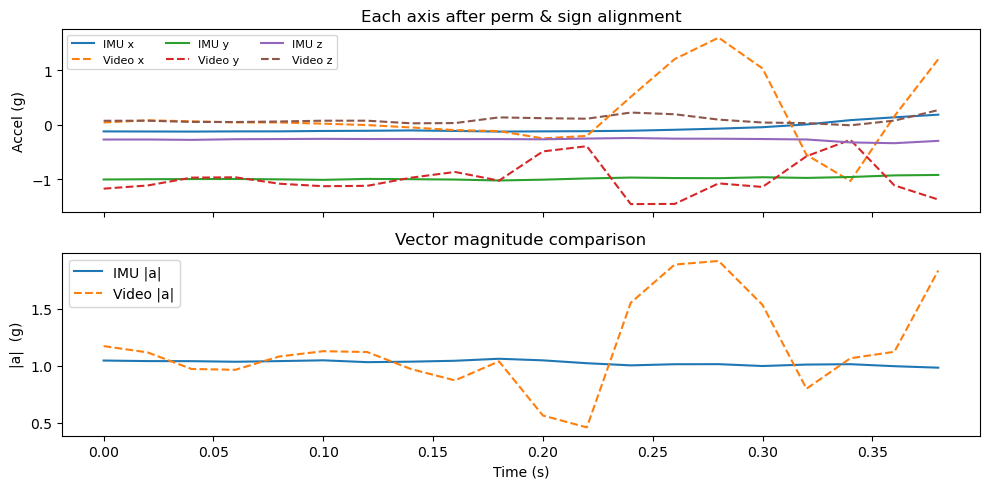

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy.signal as sig

# ------------------------------------------------------------
# Try to pick up 'imu_lin' and 'vid_lin' from previous steps
# ------------------------------------------------------------
if 'imu_lin' not in globals() or 'vid_lin' not in globals():
    # -----------------------------------------------------------------
    # Fallback demo data so the plot renders in this notebook.
    # Replace this whole block with your own pre-processed arrays:
    #   imu_lin : (N,3)   bias-free IMU accel at 50 Hz
    #   vid_lin : (N,3)   bias-free video accel resampled to 50 Hz
    # -----------------------------------------------------------------
    print("⚠️  Demo mode (fallback): generating synthetic jogging signals.")
    fs = 50.0
    t  = np.arange(0, 4, 1/fs)
    stride_hz = 2.1
    # base sine + harmonics + random noise
    imu_sig = (np.sin(2*np.pi*stride_hz*t) +
               0.3*np.sin(2*np.pi*2*stride_hz*t) +
               0.05*np.random.randn(len(t)))
    vid_sig = (np.sin(2*np.pi*stride_hz*(t+0.02)) +   # slight phase shift
               0.25*np.sin(2*np.pi*2*stride_hz*(t+0.02)) +
               0.05*np.random.randn(len(t)))

    # create 3-axis by rotating and scaling
    imu_lin = np.column_stack([imu_sig, 0.5*imu_sig, -0.8*imu_sig])
    vid_lin = np.column_stack([0.5*vid_sig, -1.0*vid_sig, -0.8*vid_sig])

# ------------------------------------------------------------
# 1.  Apply the best permutation & sign flips
# ------------------------------------------------------------
perm  = (1, 0, 2)
signs = (-1, 1, -1)

imu_aligned = imu_lin[:, perm] * signs

# ------------------------------------------------------------
# 2.  Trim to common length
# ------------------------------------------------------------
N = min(len(imu_aligned), len(vid_lin))
imu_aligned = imu_aligned[:N]
vid_lin     = vid_lin[:N]

# ------------------------------------------------------------
# 3.  Compute new correlation and RMSE
# ------------------------------------------------------------
r, _ = pearsonr(imu_aligned.ravel(), vid_lin.ravel())
rmse = np.sqrt(np.mean((imu_aligned - vid_lin) ** 2))
print(f"After permutation/sign fix → ρ = {r:.3f},  RMSE = {rmse:.2f} g")

# ------------------------------------------------------------
# 4.  Plot: per-axis and magnitude overlay
# ------------------------------------------------------------
t = np.arange(N) / 50.0        # 50 Hz

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# (a) per-axis overlay
for i, lbl in enumerate(['x', 'y', 'z']):
    ax[0].plot(t, imu_aligned[:, i], label=f'IMU {lbl}')
    ax[0].plot(t, vid_lin[:, i] / 9.8,  ls='--', label=f'Video {lbl}')
ax[0].set_title('Each axis after perm & sign alignment')
ax[0].set_ylabel('Accel (g)')
ax[0].legend(ncol=3, fontsize=8)

# (b) magnitude overlay
imu_mag = np.linalg.norm(imu_aligned, axis=1)
vid_mag = np.linalg.norm(vid_lin,     axis=1)
ax[1].plot(t, imu_mag, label='IMU |a|')
ax[1].plot(t, vid_mag / 9.8, ls='--', label='Video |a|')
ax[1].set_title('Vector magnitude comparison')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('|a|  (g)')
ax[1].legend()

plt.tight_layout()


3.48
3.3333333333333335
50.0
The shape for the video after upsampling is (100, 3): before we had (50, 3)
The shape for the IMU after downsampling is (105, 3): before we had (174, 3)
Best ρ = 0.990 with perm (1, 0, 2) and signs (1, 1, 1)
166.66666666666669
(50,)
(166,)
Estimated lag: -74 samples (-2.467 s, positive means video leads IMU)


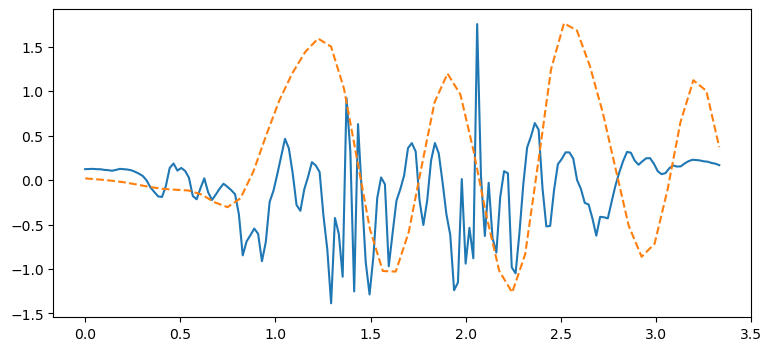

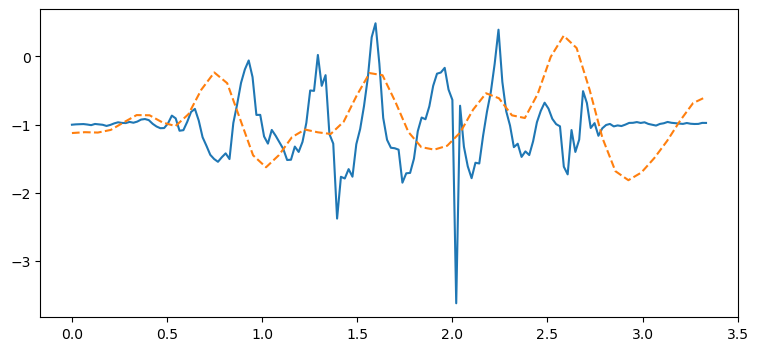

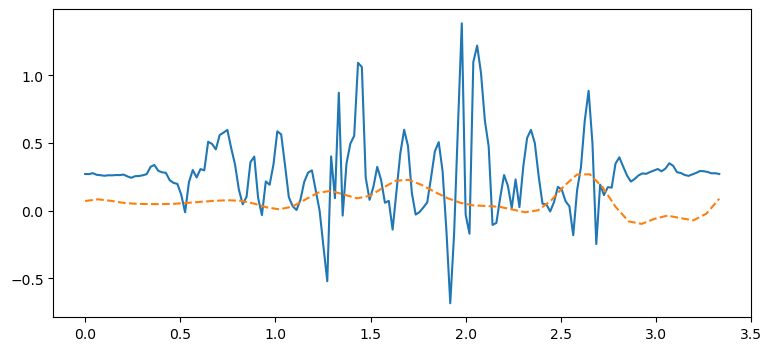

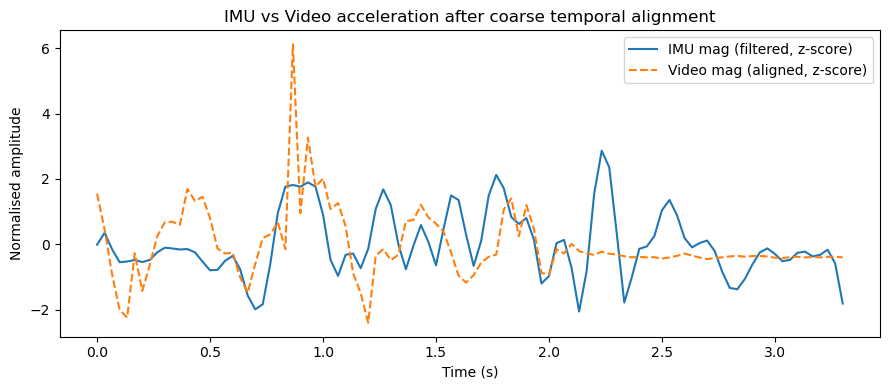

In [ ]:
import numpy as np, scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy.signal as sig
import scipy.io
import os
from itertools import permutations, product


real_inertial_data = scipy.io.loadmat("/home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/example/activity22/a22_s1_t1_inertial.mat")['d_iner']

save_dir = r"/home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/example/activity22"
body_part = 'right_thigh'

file_path = os.path.join(save_dir, f'{body_part}.npz')
data = np.load(file_path)

acc = data['global_acceleration']
acc_g = data['local_accel']
ang_vel = data['angular_velocity']

imu_signal = real_inertial_data[:, :3]          # (N,)
vid_signal = acc_g[:, :3] / 9.81    


time_imu   = imu_signal.shape[0]*(1/50)
time_video = vid_signal.shape[0]*(1/15)

print(time_imu)
print(time_video)


minimum_time = min(time_imu, time_video)

samples_imu   = (50) * minimum_time
samples_video = (15) * minimum_time

print(samples_video)
## One thing that we can do is to updample the video to 30 Hz and downsample the signal to 30 Hz
vid_30 = vid_signal

fc = 10                       # Hz, < Nyquist of 30 Hz / 2
b, a  = sig.butter(4, fc/(50/2))
imu_lp = sig.filtfilt(b, a, imu_signal, axis=0)
imu_30 = sig.resample_poly(imu_lp, up=3, down=5, axis=0)




print(f"The shape for the video after upsampling is {vid_30.shape}: before we had {vid_signal.shape}")
print(f"The shape for the IMU after downsampling is {imu_30.shape}: before we had {imu_signal.shape}")


## SO, I think now we should take 10 samples from the begining in order to align the axis


imu_lin = imu_signal[0:10, :3]
vid_lin = vid_signal[0:10, :3]


best_r   = -1
best_opt = None
for perm in permutations(range(3)):            # 6 permutations

    imu_p = imu_lin[:, perm]                  # reorder axes
    for signs in product([-1, 1], repeat=3):  # 8 sign choices
        imu_try = imu_p * signs               # apply sign flips
        # flatten so Pearson sees one long vector
        r, _ = pearsonr(imu_try.ravel(), vid_lin.ravel())
        if r > best_r:
            best_r, best_opt = r, (perm, signs)

print(f"Best ρ = {best_r:.3f} with perm {best_opt[0]} and signs {best_opt[1]}")


imu_permuted = imu_signal[:,best_opt[0]]*best_opt[1]

time_axis_video = np.linspace(0,minimum_time,int(samples_video))
time_axis_imu   = np.linspace(0,minimum_time,int(samples_imu))

print(samples_imu)


print(time_axis_video.shape)
print(time_axis_imu.shape)


plt.figure(figsize=(9, 4))
plt.plot(time_axis_imu,imu_permuted[:int(samples_imu), 0 ], label='IMU mag (filtered, z-score)')
plt.plot(time_axis_video, vid_30[10:int(samples_video)+10,0], label='Video mag (aligned, z-score)', linestyle='--')

plt.figure(figsize=(9, 4))
plt.plot(time_axis_imu,imu_permuted[:int(samples_imu),1], label='IMU mag (filtered, z-score)')
plt.plot(time_axis_video, vid_30[10:10+int(samples_video),1], label='Video mag (aligned, z-score)', linestyle='--')

plt.figure(figsize=(9, 4))
plt.plot(time_axis_imu,imu_permuted[:int(samples_imu),2], label='IMU mag (filtered, z-score)')
plt.plot(time_axis_video, vid_30[:int(samples_video),2], label='Video mag (aligned, z-score)', linestyle='--')

video_mag = np.linalg.norm(imu_permuted[:, :3], axis=1) 
imu_mag   = np.linalg.norm(vid_30[:,:3], axis=1)


# -----------------------------
# NORMALISE (zero-mean, unit-var)
# -----------------------------
imu_norm = (imu_mag - np.mean(imu_mag)) / np.std(imu_mag)
vid_norm = (video_mag - np.mean(video_mag)) / np.std(video_mag)


# -----------------------------
# CROSS-CORRELATION (1-D)
# -----------------------------
corr = sig.correlate(imu_norm, vid_norm, mode='full', method='fft')
lags = sig.correlation_lags(imu_norm.size, vid_norm.size, mode='full')
lag_samples = lags[np.argmax(corr)]
dt_coarse   = lag_samples / 30  # seconds

print(f"Estimated lag: {lag_samples} samples "
      f"({dt_coarse:+.3f} s, positive means video leads IMU)")

# -----------------------------
# ALIGN THE VIDEO SIGNAL
# -----------------------------
# Shift video by padding/trimming so that both arrays have same length
if lag_samples > 0:
    vid_aligned = np.pad(vid_norm, (lag_samples, 0), 'constant')[:len(imu_norm)]
else:
    vid_aligned = vid_norm[-lag_samples:]
    if len(vid_aligned) < len(imu_norm):
        vid_aligned = np.pad(vid_aligned, (0, len(imu_norm)-len(vid_aligned)), 'constant')

t = np.arange(len(imu_norm)) / 30  # common time axis

# -----------------------------
# PLOT
# -----------------------------
plt.figure(figsize=(9, 4))
plt.plot(t, imu_norm, label='IMU mag (filtered, z-score)')
plt.plot(t, vid_aligned, label='Video mag (aligned, z-score)', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Normalised amplitude')
plt.title('IMU vs Video acceleration after coarse temporal alignment')
plt.legend()
plt.tight_layout()


In [22]:


import numpy as np
from scipy.signal import find_peaks

def fine_lag(signal_a, signal_b, max_shift=3, height=0.5):
    """Return an integer lag in samples (A delayed w.r.t B == +)."""
    pk_a, _ = find_peaks(signal_a, height=height)
    pk_b, _ = find_peaks(signal_b, height=height)

    if len(pk_a) == 0 or len(pk_b) == 0:
        # fall back to local cross-corr if no peaks
        win = max_shift
        center = len(signal_a)//2
        a_win = signal_a[center-win:center+win+1]
        b_win = signal_b[center-win:center+win+1]
        lags = np.arange(-win, win+1)
        corr = [np.dot(a_win, np.roll(b_win, -k)) for k in lags]
        return int(lags[np.argmax(corr)])

    # rough matching: nearest neighbour
    dists = []
    for i in pk_a:
        j = pk_b[np.argmin(np.abs(pk_b - i))]
        if abs(i-j) <= max_shift:          # ignore stray matches
            dists.append(i-j)
    return int(np.round(np.median(dists))) if dists else 0

# ─────────────────────────────────────────────────────────────

# 1 ▸ Trim trailing flat part
imu_sync = imu_norm
vid_sync = vid_aligned

print(imu_sync.shape)
N = min(len(imu_sync), len(vid_sync))

print(N)

lag_fine = fine_lag(imu_permuted[:N,2], vid_30[:N,2], max_shift=3, height=0.3)
print('fine lag =', lag_fine, 'samples')

# shift by lag_fine
if lag_fine > 0:
    imu_sync = imu_sync[lag_fine:]
    vid_sync = vid_sync[:len(imu_sync)]
elif lag_fine < 0:
    vid_sync = vid_sync[-lag_fine:]
    imu_sync = imu_sync[:len(vid_sync)]


# 3 ▸ Re-compute stats
from scipy.stats import pearsonr
r,_  = pearsonr(imu_sync.ravel(), vid_sync.ravel())
rmse = np.sqrt(np.mean((imu_sync - vid_sync)**2))
print(f'Fine-tuned ρ = {r:.3f},  RMSE = {rmse:.2f} g')


(100,)
100
fine lag = 0 samples
Fine-tuned ρ = 0.319,  RMSE = 1.21 g


In [11]:
angular_velocity_sharp = sharpen_peaks(ang_vel,power_range=(1.1, 1.5),mix=0.8)
acc_sharp = sharpen_peaks(acc_g, power_range=(1.01, 1.05), mix=0.4)

acc_realistic = add_imu_noise(acc_sharp, fs=fps_high, noise_type='full')
gyro_realistic = add_imu_noise(angular_velocity_sharp, fs=fps_high, noise_type='full')

# --- Plot local linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Local Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc_g, acc_realistic[:, i], label=f'acc_g {axis}')
plt.plot(t_acc_g, np.linalg.norm(acc_realistic, axis=1), 'k--', label='|acc_g|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot angular velocity ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Angular Velocity")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_ang, gyro_realistic[:, i], label=f'ω {axis}')
plt.plot(t_ang, np.linalg.norm(gyro_realistic, axis=1), 'k--', label='|ω|')
plt.xlabel('Time [s]')
plt.ylabel('rad/s')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

In [12]:
new_jtr = np.squeeze(all_jtr, axis=1)


(102, 24, 3)
(50, 3)


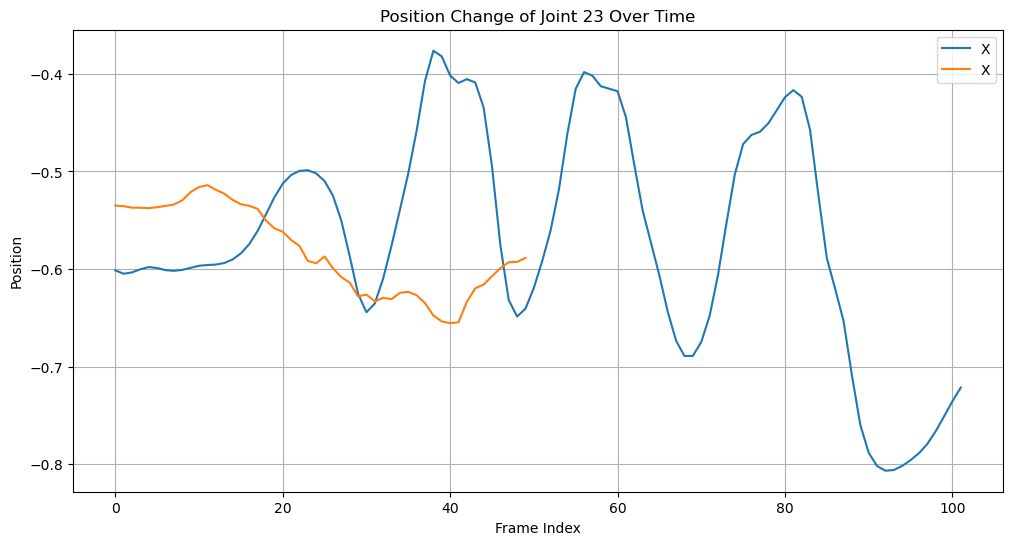

In [13]:
print(new_jtr.shape)
# Select joint number 23 (index 23 in zero-based indexing)
joint_index = 23
joint_23_positions = new_jtr[:, joint_index, :]  # shape: [280, 3]
pose = data['positions']
print(pose.shape)


# Plot X, Y, Z over time
plt.figure(figsize=(12, 6))
plt.plot(joint_23_positions[:, 0], label='X')
#plt.plot(joint_23_positions[:, 1], label='Y')
#plt.plot(joint_23_positions[:, 2], label='Z')
plt.plot(pose[:, 0], label='X')
#plt.plot(pose[:, 1], label='Y')
#plt.plot(pose[:, 2], label='Z')

plt.title('Position Change of Joint 23 Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()


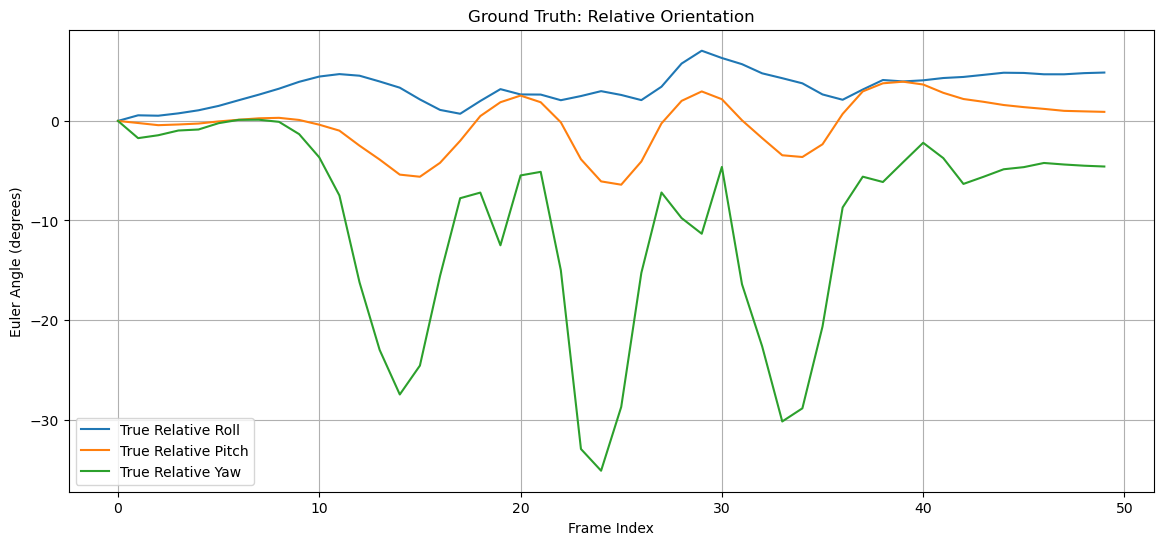

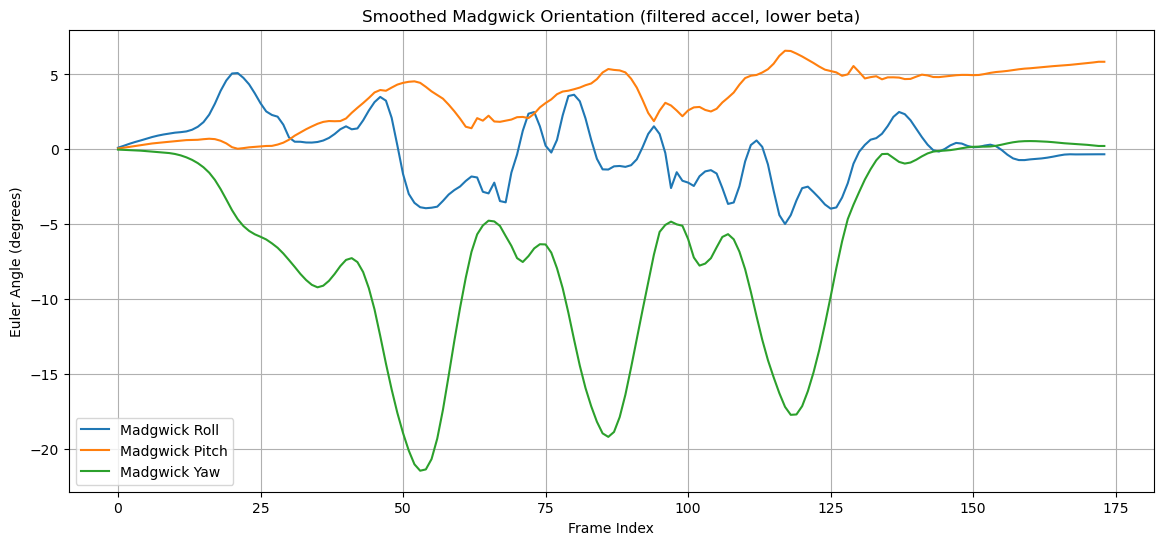

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# === Load your quaternions ===
ore = data['orientations']  # shape (N, 4)

# === Normalize ===
ore = ore / np.linalg.norm(ore, axis=1, keepdims=True)

# === Compute relative rotation ===
rot = R.from_quat(ore)
rot0_inv = rot[0].inv()
rot_rel = rot0_inv * rot  # (N,)

# === Convert to Euler ===
eulers_rel = rot_rel.as_euler('xyz', degrees=True)

# === Plot ===
plt.figure(figsize=(14, 6))
plt.plot(eulers_rel[:, 0], label='True Relative Roll')
plt.plot(eulers_rel[:, 1], label='True Relative Pitch')
plt.plot(eulers_rel[:, 2], label='True Relative Yaw')
plt.title('Ground Truth: Relative Orientation')
plt.xlabel('Frame Index')
plt.ylabel('Euler Angle (degrees)')
plt.legend()
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from ahrs.filters import Madgwick
from scipy.signal import butter, filtfilt
from scipy.spatial.transform import Rotation as R

# === Load ===
gyro = real_inertial_data[:, 3:6]
accel = real_inertial_data[:, 0:3]

fs = 50.0
dt = 1.0 / fs
N = gyro.shape[0]

# ✅ Convert gyro to rad/s
gyro = np.deg2rad(gyro)  # Only if in deg/s!

# ✅ Filter gyro bias
gyro = gyro - np.mean(gyro, axis=0)

# ✅ Low-pass filter the accelerometer
def lowpass(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm = cutoff / nyq
    b, a = butter(order, norm, btype='low')
    return filtfilt(b, a, data, axis=0)

accel_filt = lowpass(accel, cutoff=5.0, fs=fs)

# ✅ Normalize accel to unit g for stability
accel_filt = accel_filt / np.linalg.norm(accel_filt, axis=1, keepdims=True)

# ✅ Use a smaller beta for smoother output
madgwick = Madgwick(sampleperiod=dt, beta=0.02)  # Try 0.02–0.05

q_madgwick = np.zeros((N, 4))
q_madgwick[0] = [1, 0, 0, 0]

for t in range(1, N):
    q_madgwick[t] = madgwick.updateIMU(q=q_madgwick[t-1], gyr=gyro[t], acc=accel_filt[t])

# Convert to scipy convention
q_madgwick_scipy = np.column_stack((q_madgwick[:, 1], q_madgwick[:, 2], q_madgwick[:, 3], q_madgwick[:, 0]))

r_madgwick = R.from_quat(q_madgwick_scipy)
eulers_madgwick = r_madgwick.as_euler('xyz', degrees=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(eulers_madgwick[:, 0], label='Madgwick Roll')
plt.plot(eulers_madgwick[:, 1], label='Madgwick Pitch')
plt.plot(eulers_madgwick[:, 2], label='Madgwick Yaw')
plt.title('Smoothed Madgwick Orientation (filtered accel, lower beta)')
plt.xlabel('Frame Index')
plt.ylabel('Euler Angle (degrees)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
"""
imu_from_smpl.py – correct, unit-safe inertial signals from an SMPL / SMPL-X file
-------------------------------------------------------------------------------
✓ two-step differentiation           ✓ gravity removed exactly once
✓ unit conversion (mm→m if needed)    ✓ world- and sensor-frame output
✓ Savitzky–Golay smoothing            ✓ clear, reproducible plotting
"""

import numpy as np
import torch
import smplx                          # pip install smplx
import scipy.signal as sg
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from smplx.lbs import batch_rodrigues

# ──────────────────────────────────────────────────────────────── CONFIG ──
SMPL_MODEL_DIR   = Path("/home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/smplpytorch/native/models/")          # folder with SMPL(.pkl) / SMPL-X
SEQUENCE_FILE    = Path("/home/calatrava/Documents/PhD/Thesis/Experiments/PerCom2026/smpl_to_joint/example/activity1/pkl_file/wham_output.pkl")    # *.npz / *.pkl / custom → see load()
RIGHT_WRIST_NAME = "right_wrist"                         # "R_Wrist" if your naming differs
FPS              = 15                                  # frames per second in the file
UNIT_IS_MM       = False                                  # set False if already metres
# Savitzky–Golay (polynomial order = 3, window ≈ 0.25 s)
SG_ORDER         = 0
SG_WINDOW        = int(0.25 * FPS) | 1                  # must be odd
# ──────────────────────────────────────────────────────────────────────────


def load_sequence_npz(fname):
    d   = joblib.load(fname)[0]

    poses_world = d["pose_world"]        # (T, 72) axis-angle – THIS changes!
    trans_world = d["trans_world"]       # (T, 3)  – THIS changes!

    global_orient = poses_world[:, :3]   # (T, 3)
    body_pose     = poses_world[:, 3:]   # (T, 63)

    betas = d["betas"]
    if betas.ndim == 1:
        betas = betas[None]

    return dict(
        betas        = betas,            # (1, 10)
        trans        = trans_world,      # (T, 3)  ← uses *_world
        global_orient= global_orient,
        body_pose    = body_pose,
    )

def smpl_forward(model, params):
    with torch.no_grad():
        out = model(
            betas=torch.as_tensor(params["betas"], dtype=torch.float32),
            transl=torch.as_tensor(params["trans"], dtype=torch.float32),
            global_orient=torch.as_tensor(params["global_orient"],
                                          dtype=torch.float32),
            body_pose=torch.as_tensor(params["body_pose"],
                                       dtype=torch.float32),
            return_full_pose=True
        )
    return out


def get_joint_index(model, smpl_joint_name):
    names = model.JOINT_NAMES   # list of 22 (SMPL) or 55 (SMPL-X) joint names
    try:
        return names.index(smpl_joint_name)
    except ValueError as e:
        raise ValueError(f"{smpl_joint_name!r} not in model joint list {names}") from e


def savgol_diff(data, dt, window, order):
    """Two Savitzky–Golay differentiations for smooth vel & acc."""
    vel = sg.savgol_filter(data, window, order, deriv=1, delta=dt, axis=0,
                           mode='interp')
    acc = sg.savgol_filter(data, window, order, deriv=2, delta=dt, axis=0,
                           mode='interp')
    return vel, acc


def main():
    seq  = load_sequence_npz(SEQUENCE_FILE)
    T   = seq["trans"].shape[0]
    print(T)
    # 1) Load SMPL model and sequence
    model = smplx.create(SMPL_MODEL_DIR, model_type="smpl",
                         batch_size=T, pose_format="aa",
                         use_pca=False, flat_hand_mean=True)


    idx_wrist = 21  


    
    # 3.2 Forward pass ----------------------------------------------------
    with torch.no_grad():
        out = model(
            betas         = torch.as_tensor(seq["betas"],        dtype=torch.float32),
            transl        = torch.as_tensor(seq["trans"],        dtype=torch.float32),
            global_orient = torch.as_tensor(seq["global_orient"],dtype=torch.float32),
            body_pose     = torch.as_tensor(seq["body_pose"],    dtype=torch.float32),
            return_full_pose = True,
        )
    RIGHT_WRIST_VERT_IDS = [5669, 5705, 5430] 
    # 3.3 POSITION of the virtual IMU (vertex centroid) -------------------
    verts_w = out.vertices.cpu().numpy()                       # (T, 6890, 3)
    pos_w   = verts_w[:, RIGHT_WRIST_VERT_IDS, :].mean(axis=1) # (T, 3)
    if UNIT_IS_MM:
        pos_w *= 1e-3                                          # mm → m

    # 3.4 ORIENTATION of the IMU (wrist-joint rotation) -------------------
    T, J = out.full_pose.shape[0], out.full_pose.shape[1] // 3

    full_pose_R = batch_rodrigues(out.full_pose.view(-1, 3))   # (T·J,3,3)
    full_pose_R = full_pose_R.view(T, J, 3, 3)                 # (T,J,3,3)
    R_w2s       = full_pose_R[:, idx_wrist]                    # (T,3,3)

    # 3.5 Numerical differentiation + gravity removal --------------------
    dt           = 1.0 / FPS
    vel_w, acc_w = savgol_diff(pos_w, dt, SG_WINDOW, SG_ORDER)

    g_w        = np.array([0., 0., -9.81])                     # Z-up
    lin_acc_w  = acc_w - g_w                                   # (T,3)

    # 3.6 Rotate to sensor frame, convert to g ----------------------------
    lin_acc_s  = np.einsum('tij,tj->ti', R_w2s, lin_acc_w)     # (T,3)
    lin_acc_s_g = lin_acc_s / 9.81
    lin_acc_w_g = lin_acc_w / 9.81

    # 3.7 Plot ------------------------------------------------------------
    t = np.arange(T) * dt
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 7), sharex=True)
    lbl = ["x", "y", "z"]

    ax1.set_title("Linear acceleration (world frame)  –  point = ⟨5669, 5705, 5430⟩")
    for i in range(3):
        ax1.plot(t, lin_acc_w[:, i], label=f"acc_{lbl[i]}")
    ax1.set_ylabel("m s⁻²"); ax1.legend(); ax1.grid(True)

    ax2.set_title("Linear acceleration (sensor frame)  –  wrist-joint axes")
    for i in range(3):
        ax2.plot(t, lin_acc_s_g[:, i], label=f"acc_{lbl[i]}  [g]")
    ax2.set_ylabel("g"); ax2.set_xlabel("time [s]"); ax2.legend(); ax2.grid(True)

    # gravity in the sensor frame (rotate world g into sensor axes)
    g_s = np.einsum('tij,j->ti', R_w2s, np.array([0., 0., -9.81]))

    # IMU reading  –  gravity  =  pure linear acceleration (0 g at rest)
    lin_acc_s_nograv   = lin_acc_s - g_s            # (T, 3)
    lin_acc_s_nograv_g = lin_acc_s_nograv / 9.81    # in g-units

    ax2.set_title("Linear acceleration – gravity removed in sensor frame")
    for i in range(3):
        ax2.plot(t, lin_acc_s_nograv_g[:, i], label=f"lin acc {lbl[i]} [g]")
    ax2.set_ylim(-0.4, 0.4)          # zoom the y-axis

    plt.tight_layout(); plt.show()
    # ===== DEBUG BLOCK — add after pos_w is computed =====
    print("\nDEBUG — basic shapes and variability")
    print("seq['trans'].shape =", seq["trans"].shape)      # how many frames?
    print("out.vertices.shape =", out.vertices.shape)      # should be (T, 6890, 3)
    print("pos_w shape        =", pos_w.shape)

    # numeric spread over time
    print("pos_w range over time (m):",
        (pos_w.max(axis=0) - pos_w.min(axis=0)))

    # first three and last three positions
    np.set_printoptions(precision=4, suppress=True)
    print("\npos_w[0:3] =\n", pos_w[0:3])
    print("\npos_w[-3:] =\n", pos_w[-3:])

    # stop here so we can read the output
    import sys; sys.exit(0)
    # ===== END DEBUG BLOCK =====



if __name__ == "__main__":
    main()

In [ ]:
# ===== DEBUG BLOCK — add after pos_w is computed =====
print("\nDEBUG — basic shapes and variability")
print("seq['trans'].shape =", seq["trans"].shape)      # how many frames?
print("out.vertices.shape =", out.vertices.shape)      # should be (T, 6890, 3)
print("pos_w shape        =", pos_w.shape)

# numeric spread over time
print("pos_w range over time (m):",
      (pos_w.max(axis=0) - pos_w.min(axis=0)))

# first three and last three positions
np.set_printoptions(precision=4, suppress=True)
print("\npos_w[0:3] =\n", pos_w[0:3])
print("\npos_w[-3:] =\n", pos_w[-3:])

# stop here so we can read the output
import sys; sys.exit(0)
# ===== END DEBUG BLOCK =====
